### 2. (20 points) k-nearest neighbors
***

## This is the k-nearest neighbors workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement k-nearest neighbors.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with the data, training and evaluating a simple classifier, k-fold cross validation, and as a Python refresher.

## Import the appropriate libraries

In [1]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from utils.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Set the path to the CIFAR-10 data
cifar10_dir = 'data/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


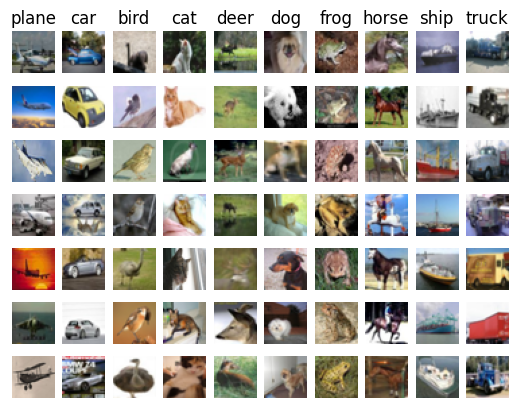

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# K-nearest neighbors

In the following cells, you will build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [5]:
# Import the KNN class

from nndl import KNN

In [6]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

## Questions

(1) Describe what is going on in the function knn.train().

(2) What are the pros and cons of this training step?

## Answers

(1) Just store the training data into class.

(2) Pros: the implementation is pretty simple and readable. Cons: inference will be time-consuming.

## KNN prediction

In the following sections, you will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [7]:
# Implement the function compute_distances() in the KNN class.
# Do not worry about the input 'norm' for now; use the default definition of the norm
# in the code, which is the 2-norm.
# You should only have to fill out the clearly marked sections.

import time
time_start = time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Time to run code: 37.207756757736206
Frobenius norm of L2 distances: 7906696.077040902


#### Really slow code

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops.

If you implemented this correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [8]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print(
    'Difference in L2 distances between your KNN implementations (should be 0): {}'.format(
        np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')
    )
)

Time to run code: 0.26317715644836426
Difference in L2 distances between your KNN implementations (should be 0): 0.0


#### Speedup

Depending on your computer speed, you should see a 10-100x speed up from vectorization.  On our computer, the vectorized form took 0.36 seconds while the naive implementation took 38.3 seconds. 

### Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [9]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

error = 1

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the error rate by calling predict_labels on the test 
#   data with k = 1.  Store the error rate in the variable error.
# ================================================================ #


def compute_error(y, y_pred):
    return np.mean([y1 != y2 for y1, y2 in zip(y, y_pred)])

y_pred = knn.predict_labels(dists_L2_vectorized)
error = compute_error(y_test, y_pred)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print(error)

0.726


If you implemented this correctly, the error should be: 0.726.

This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great, considering that chance levels are 10%.

# Optimizing KNN hyperparameters

In this section, we'll take the KNN classifier that you have constructed and perform cross-validation to choose a best value of $k$, as well as a best choice of norm.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [10]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# ================================================================ #
# YOUR CODE HERE:
#   Split the training data into num_folds (i.e., 5) folds.
#   X_train_folds is a list, where X_train_folds[i] contains the 
#      data points in fold i.
#   y_train_folds is also a list, where y_train_folds[i] contains
#      the corresponding labels for the data in X_train_folds[i]
# ================================================================ #

train_idxs = list(range(num_training))
np.random.seed(413)
np.random.shuffle(train_idxs)
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

training k=1...
error=0.7310000000000001
training k=2...
error=0.7516
training k=3...
error=0.7504000000000001
training k=5...
error=0.732
training k=7...
error=0.7242
training k=10...
error=0.7305999999999999
training k=15...
error=0.7282
training k=20...
error=0.7302
training k=25...
error=0.7335999999999999
training k=30...
error=0.7342000000000001
best k=7, cv error=0.7242


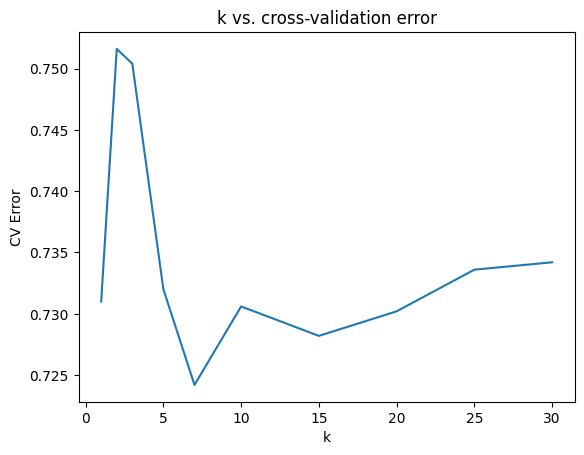

Computation time: 73.69


In [11]:
time_start =time.time()

ks = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the cross-validation error for each k in ks, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of k vs. cross-validation error. Since 
#   we are assuming L2 distance here, please use the vectorized code!
#   Otherwise, you might be waiting a long time.
# ================================================================ #

def get_ith_fold(X_folds, y_folds, i):
    X_train_cv = np.concatenate(X_folds[:i] + X_folds[i + 1:])
    y_train_cv = np.concatenate(y_folds[:i] + y_folds[i + 1:])
    X_valid = X_folds[i] 
    y_valid = y_folds[i]
    return X_train_cv, y_train_cv, X_valid, y_valid


def get_knn_predictions(X_train, y_train, X_test, norm=None, k=1):
    knn = KNN()
    knn.train(X=X_train, y=y_train)
    if norm is None:
        dists = knn.compute_L2_distances_vectorized(X=X_test)
    else:
        dists = knn.compute_distances(X=X_test, norm=norm)
    y_pred = knn.predict_labels(dists, k=k)
    return y_pred


k2error = {}

# search best k
for k in ks:
    print(f"training k={k}...")
    errors = []

    for i in range(num_folds):
        # generate cv training data
        X_train_cv, y_train_cv, X_valid, y_valid = get_ith_fold(X_train_folds, y_train_folds, i)
        
        # generate knn predictions
        y_pred = get_knn_predictions(X_train_cv, y_train_cv, X_valid, k=k)
        
        # compute error
        error = compute_error(y_valid, y_pred)
        errors.append(error)

    cv_error = np.mean(errors)
    k2error[k] = cv_error
    print(f"error={cv_error}")

best_k = min(k2error, key=k2error.get)
print(f"best k={best_k}, cv error={k2error[best_k]}")

# plot k vs cv error
plt.plot(ks, [k2error[k] for k in ks])
plt.title("k vs. cross-validation error")
plt.ylabel("CV Error")
plt.xlabel("k")
plt.show()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Computation time: %.2f'%(time.time()-time_start))

## Questions:

(1) What value of $k$ is best amongst the tested $k$'s?

(2) What is the cross-validation error for this value of $k$?

## Answers:

(1) 7.

(2) 0.7242.

### Optimizing the norm

Next, we test three different norms (the 1, 2, and infinity norms) and see which distance metric results in the best cross-validation performance.

training norm=L1...
error=0.6978
training norm=L2...
error=0.7242
training norm=Linf...
error=0.8333999999999999
best norm=L1, cv error=0.6978


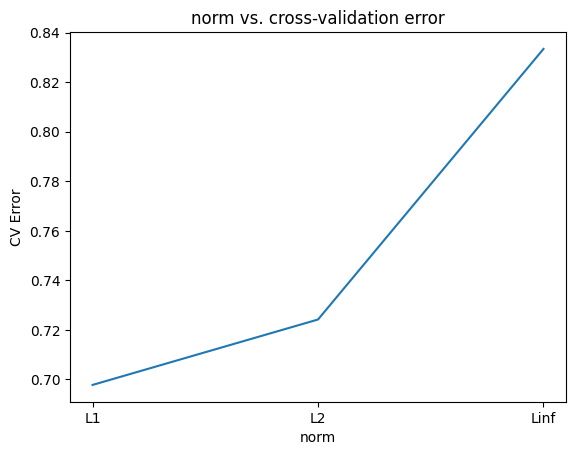

Computation time: 561.90


In [12]:
time_start =time.time()

L1_norm = lambda x: np.linalg.norm(x, ord=1)
L2_norm = lambda x: np.linalg.norm(x, ord=2)
Linf_norm = lambda x: np.linalg.norm(x, ord= np.inf)
norms = [L1_norm, L2_norm, Linf_norm]

# ================================================================ #
# YOUR CODE HERE:
#   Calculate the cross-validation error for each norm in norms, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of the norm used vs the cross-validation error
#   Use the best cross-validation k from the previous part.  
#
#   Feel free to use the compute_distances function.  We're testing just
#   three norms, but be advised that this could still take some time.
#   You're welcome to write a vectorized form of the L1- and Linf- norms
#   to speed this up, but it is not necessary.
# ================================================================ #

norm2error = {}
norm_names = ["L1", "L2", "Linf"]
norms[1] = None  # to accelerate with the vectorized L2-norm
k = best_k

# search best norm
for norm_name, norm in zip(norm_names, norms):
    print(f"training norm={norm_name}...")
    errors = []

    for i in range(num_folds):
        # generate cv training data
        X_train_cv, y_train_cv, X_valid, y_valid = get_ith_fold(X_train_folds, y_train_folds, i)

        # generate knn predictions
        y_pred = get_knn_predictions(X_train_cv, y_train_cv, X_valid, norm=norm, k=k)

        # compute error
        error = compute_error(y_valid, y_pred)
        errors.append(error)

    cv_error = np.mean(errors)
    norm2error[norm_name] = cv_error
    print(f"error={cv_error}")

best_norm = min(norm2error, key=norm2error.get)
print(f"best norm={best_norm}, cv error={norm2error[best_norm]}")

# plot norm vs cv error
plt.plot(norm_names, [norm2error[norm] for norm in norm_names])
plt.title("norm vs. cross-validation error")
plt.ylabel("CV Error")
plt.xlabel("norm")
plt.show()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
print('Computation time: %.2f'%(time.time()-time_start))

## Questions:

(1) What norm has the best cross-validation error?

(2) What is the cross-validation error for your given norm and k?

## Answers: 

(1) L1 norm.

(2) 0.6978.

# Evaluating the model on the testing dataset.

Now, given the optimal $k$ and norm you found in earlier parts, evaluate the testing error of the k-nearest neighbors model.

In [13]:
error = 1

# ================================================================ #
# YOUR CODE HERE:
#   Evaluate the testing error of the k-nearest neighbors classifier
#   for your optimal hyperparameters found by 5-fold cross-validation.
# ================================================================ #

k, norm = best_k, norms[norm_names.index(best_norm)]
y_pred = get_knn_predictions(X_train, y_train, X_test, norm=norm, k=k)
error = compute_error(y_test, y_pred)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

print('Error rate achieved: {}'.format(error))

Error rate achieved: 0.712


## Question:

How much did your error improve by cross-validation over naively choosing $k=1$ and using the L2-norm?

## Answer:

It improved by 0.014.

### `knn.py`
***

In [ ]:
# import 2 useful packages for function `predict_labels`
import heapq
from collections import Counter

import numpy as np


class KNN(object):

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Inputs:
    - X is a numpy array of size (num_examples, D)
    - y is a numpy array of size (num_examples, )
    """
    self.X_train = X
    self.y_train = y

  def compute_distances(self, X, norm=None):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.
    - norm: the function with which the norm is taken.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    if norm is None:
      norm = lambda x: np.sqrt(np.sum(x**2))
      #norm = 2

    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in np.arange(num_test):
        
      for j in np.arange(num_train):
        # ================================================================ #
        # YOUR CODE HERE:
        #   Compute the distance between the ith test point and the jth       
        #   training point using norm(), and store the result in dists[i, j].     
        # ================================================================ #

        dists[i, j] = norm(X[i] - self.X_train[j])

        # ================================================================ #
        # END YOUR CODE HERE
        # ================================================================ #

    return dists

  def compute_L2_distances_vectorized(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train WITHOUT using any for loops.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    # ================================================================ #
    # YOUR CODE HERE:
    #   Compute the L2 distance between the ith test point and the jth       
    #   training point and store the result in dists[i, j].  You may 
    #   NOT use a for loop (or list comprehension).  You may only use
    #   numpy operations.
    #
    #   HINT: use broadcasting.  If you have a shape (N,1) array and
    #   a shape (M,) array, adding them together produces a shape (N, M) 
    #   array.
    # ================================================================ #

    sum_of_sqr_test = (X ** 2).sum(axis=1).reshape((-1, 1))
    sum_of_sqr_train = (self.X_train ** 2).sum(axis=1).reshape((1, -1))
    inner_products = X.dot(self.X_train.T)
    dists = (sum_of_sqr_test + sum_of_sqr_train - 2 * inner_products) ** 0.5

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return dists


  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in np.arange(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      # (useless for here)
      closest_y = []
      # ================================================================ #
      # YOUR CODE HERE:
      #   Use the distances to calculate and then store the labels of 
      #   the k-nearest neighbors to the ith test point.  The function
      #   numpy.argsort may be useful.
      #   
      #   After doing this, find the most common label of the k-nearest
      #   neighbors.  Store the predicted label of the ith training example
      #   as y_pred[i].  Break ties by choosing the smaller label.
      # ================================================================ #
  
      n_candidate = dists.shape[1]
      nearest_idxs = heapq.nsmallest(k, range(n_candidate), key=lambda j: dists[i, j])
      count2class = {
        count: -class_  # break ties by choosing the smaller label.
        for class_, count in Counter(self.y_train[nearest_idxs]).items()
      }
      y_pred[i] = -max(count2class.items())[1]

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

    return y_pred